# Import necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

# Define Foursquare Credentials and Version

In [105]:
CLIENT_ID = 'LF5PRFM4UFYHHD0YLPPRRBVL4RUDDC3YE5KHWHIJXDDP5FF3' # your Foursquare ID
CLIENT_SECRET = 'BIVRZAGHKIUX1ALQNQ1TYSGN0DIAELB2VNYCPYC25YHKSFND' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# Define a function to get the latitude and longitude of a given location using geopy

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

# Define a function to get the list of Venues using the Foursquare API

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# Define a function to get the Venue details - Rating, Tips, Likes - for ranking

In [5]:
def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# Define a function to get NYC data - Boroughs and Neighborhoods and their Latitude, Longitude

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

# Get New York City data

In [7]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [9]:
new_york_data.shape

(306, 4)

In [10]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# Plot the number of Neighborhoods in each of the 5 Boroughs

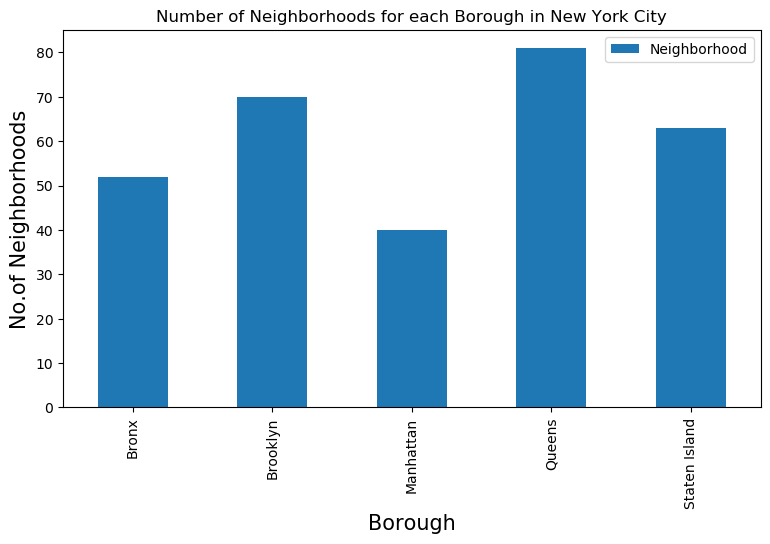

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhoods', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:
new_york_data_Bronx = new_york_data[new_york_data['Borough'] == 'Bronx']
new_york_data_Brooklyn = new_york_data[new_york_data['Borough'] == 'Brooklyn']
new_york_data_Manhattan = new_york_data[new_york_data['Borough'] == 'Manhattan']
new_york_data_Queens = new_york_data[new_york_data['Borough'] == 'Queens']
new_york_data_Staten_Island = new_york_data[new_york_data['Borough'] == 'Staten Island']

In [17]:
new_york_data_Bronx.shape

(52, 4)

In [18]:
new_york_data_Brooklyn.shape

(70, 4)

In [19]:
new_york_data_Manhattan.shape

(40, 4)

In [20]:
new_york_data_Queens.shape

(81, 4)

In [21]:
new_york_data_Staten_Island.shape

(63, 4)

In [22]:
# prepare neighborhood list that contains Italian restaurants in Bronx
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_Bronx=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data_Bronx.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data_Bronx),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_Bronx = italian_rest_Bronx.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 52 ) Italian Restaurants in Wakefield, Bronx:0
( 2 / 52 ) Italian Restaurants in Co-op City, Bronx:0
( 3 / 52 ) Italian Restaurants in Eastchester, Bronx:0
( 4 / 52 ) Italian Restaurants in Fieldston, Bronx:0
( 5 / 52 ) Italian Restaurants in Riverdale, Bronx:1
( 6 / 52 ) Italian Restaurants in Kingsbridge, Bronx:1
( 7 / 52 ) Italian Restaurants in Woodlawn, Bronx:2
( 8 / 52 ) Italian Restaurants in Norwood, Bronx:0
( 9 / 52 ) Italian Restaurants in Williamsbridge, Bronx:0
( 10 / 52 ) Italian Restaurants in Baychester, Bronx:2
( 11 / 52 ) Italian Restaurants in Pelham Parkway, Bronx:3
( 12 / 52 ) Italian Restaurants in City Island, Bronx:3
( 13 / 52 ) Italian Restaurants in Bedford Park, Bronx:1
( 14 / 52 ) Italian Restaurants in University Heights, Bronx:0
( 15 / 52 ) Italian Restaurants in Morris Heights, Bronx:0
( 16 / 52 ) Italian Restaurants in Fordham, Bronx:10
( 17 / 52 ) Italian Restaurants in East Tremont, Bronx:0
( 18 / 52 ) Italian Restaurants in West Farms, Bronx:0
( 

In [25]:
# prepare neighborhood list that contains Italian restaurants in Brooklyn
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_Brooklyn=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data_Brooklyn.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data_Brooklyn),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_Brooklyn = italian_rest_Brooklyn.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 70 ) Italian Restaurants in Bay Ridge, Brooklyn:6
( 2 / 70 ) Italian Restaurants in Bensonhurst, Brooklyn:4
( 3 / 70 ) Italian Restaurants in Sunset Park, Brooklyn:1
( 4 / 70 ) Italian Restaurants in Greenpoint, Brooklyn:2
( 5 / 70 ) Italian Restaurants in Gravesend, Brooklyn:1
( 6 / 70 ) Italian Restaurants in Brighton Beach, Brooklyn:0
( 7 / 70 ) Italian Restaurants in Sheepshead Bay, Brooklyn:5
( 8 / 70 ) Italian Restaurants in Manhattan Terrace, Brooklyn:0
( 9 / 70 ) Italian Restaurants in Flatbush, Brooklyn:1
( 10 / 70 ) Italian Restaurants in Crown Heights, Brooklyn:0
( 11 / 70 ) Italian Restaurants in East Flatbush, Brooklyn:0
( 12 / 70 ) Italian Restaurants in Kensington, Brooklyn:0
( 13 / 70 ) Italian Restaurants in Windsor Terrace, Brooklyn:5
( 14 / 70 ) Italian Restaurants in Prospect Heights, Brooklyn:0
( 15 / 70 ) Italian Restaurants in Brownsville, Brooklyn:0
( 16 / 70 ) Italian Restaurants in Williamsburg, Brooklyn:1
( 17 / 70 ) Italian Restaurants in Bushwick, Bro

In [26]:
# prepare neighborhood list that contains Italian restaurants in Manhattan
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_Manhattan=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data_Manhattan.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data_Manhattan),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_Manhattan = italian_rest_Manhattan.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 40 ) Italian Restaurants in Marble Hill, Manhattan:0
( 2 / 40 ) Italian Restaurants in Chinatown, Manhattan:0
( 3 / 40 ) Italian Restaurants in Washington Heights, Manhattan:1
( 4 / 40 ) Italian Restaurants in Inwood, Manhattan:0
( 5 / 40 ) Italian Restaurants in Hamilton Heights, Manhattan:2
( 6 / 40 ) Italian Restaurants in Manhattanville, Manhattan:4
( 7 / 40 ) Italian Restaurants in Central Harlem, Manhattan:1
( 8 / 40 ) Italian Restaurants in East Harlem, Manhattan:3
( 9 / 40 ) Italian Restaurants in Upper East Side, Manhattan:7
( 10 / 40 ) Italian Restaurants in Yorkville, Manhattan:6
( 11 / 40 ) Italian Restaurants in Lenox Hill, Manhattan:5
( 12 / 40 ) Italian Restaurants in Roosevelt Island, Manhattan:2
( 13 / 40 ) Italian Restaurants in Upper West Side, Manhattan:5
( 14 / 40 ) Italian Restaurants in Lincoln Square, Manhattan:4
( 15 / 40 ) Italian Restaurants in Clinton, Manhattan:3
( 16 / 40 ) Italian Restaurants in Midtown, Manhattan:0
( 17 / 40 ) Italian Restaurants i

In [33]:
# prepare neighborhood list that contains Italian restaurants in Queens
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_Queens=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data_Queens.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data_Queens),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_Queens = italian_rest_Queens.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 81 ) Italian Restaurants in Astoria, Queens:3
( 2 / 81 ) Italian Restaurants in Woodside, Queens:1
( 3 / 81 ) Italian Restaurants in Jackson Heights, Queens:1
( 4 / 81 ) Italian Restaurants in Elmhurst, Queens:0
( 5 / 81 ) Italian Restaurants in Howard Beach, Queens:4
( 6 / 81 ) Italian Restaurants in Corona, Queens:3
( 7 / 81 ) Italian Restaurants in Forest Hills, Queens:2
( 8 / 81 ) Italian Restaurants in Kew Gardens, Queens:1
( 9 / 81 ) Italian Restaurants in Richmond Hill, Queens:1
( 10 / 81 ) Italian Restaurants in Flushing, Queens:0
( 11 / 81 ) Italian Restaurants in Long Island City, Queens:2
( 12 / 81 ) Italian Restaurants in Sunnyside, Queens:2
( 13 / 81 ) Italian Restaurants in East Elmhurst, Queens:1
( 14 / 81 ) Italian Restaurants in Maspeth, Queens:2
( 15 / 81 ) Italian Restaurants in Ridgewood, Queens:3
( 16 / 81 ) Italian Restaurants in Glendale, Queens:1
( 17 / 81 ) Italian Restaurants in Rego Park, Queens:1
( 18 / 81 ) Italian Restaurants in Woodhaven, Queens:0
(

In [34]:
# prepare neighborhood list that contains Italian restaurants in Staten Island
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_Staten_Island=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data_Staten_Island.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data_Staten_Island),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_Staten_Island = italian_rest_Staten_Island.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 63 ) Italian Restaurants in St. George, Staten Island:3
( 2 / 63 ) Italian Restaurants in New Brighton, Staten Island:3
( 3 / 63 ) Italian Restaurants in Stapleton, Staten Island:1
( 4 / 63 ) Italian Restaurants in Rosebank, Staten Island:4
( 5 / 63 ) Italian Restaurants in West Brighton, Staten Island:3
( 6 / 63 ) Italian Restaurants in Grymes Hill, Staten Island:0
( 7 / 63 ) Italian Restaurants in Todt Hill, Staten Island:0
( 8 / 63 ) Italian Restaurants in South Beach, Staten Island:0
( 9 / 63 ) Italian Restaurants in Port Richmond, Staten Island:0
( 10 / 63 ) Italian Restaurants in Mariner's Harbor, Staten Island:3
( 11 / 63 ) Italian Restaurants in Port Ivory, Staten Island:0
( 12 / 63 ) Italian Restaurants in Castleton Corners, Staten Island:2
( 13 / 63 ) Italian Restaurants in New Springville, Staten Island:0
( 14 / 63 ) Italian Restaurants in Travis, Staten Island:1
( 15 / 63 ) Italian Restaurants in New Dorp, Staten Island:5
( 16 / 63 ) Italian Restaurants in Oakwood, St

# Compile the list of all Italian restaurants in all 5 Boroughs from the above data

In [35]:
italian_rest_ny = italian_rest_Bronx.append(italian_rest_Brooklyn, ignore_index=True).append(italian_rest_Manhattan, ignore_index=True).append(italian_rest_Queens, ignore_index=True).append(italian_rest_Staten_Island, ignore_index=True)

In [36]:
italian_rest_ny.shape

(552, 4)

In [37]:
italian_rest_ny['Borough'].value_counts().sort_values(ascending=False)

Manhattan        138
Brooklyn         115
Staten Island    108
Queens           105
Bronx             86
Name: Borough, dtype: int64

# Plot the number of Italian Restaurants in each Borough

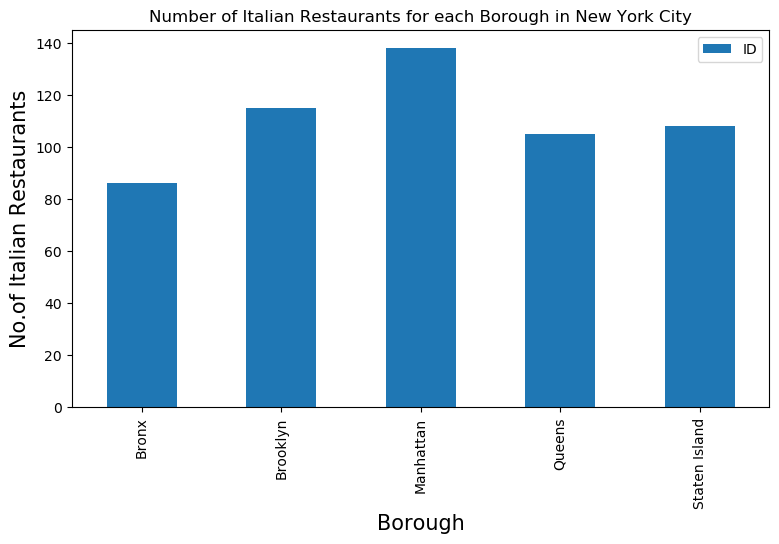

In [38]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [39]:
italian_rest_ny['Neighborhood'].value_counts().sort_values(ascending=False)

Belmont                      15
Greenwich Village            11
Fordham                      10
West Village                 10
Dongan Hills                  9
Soho                          8
Carroll Gardens               7
Upper East Side               7
Old Town                      7
Hunters Point                 6
Noho                          6
Little Neck                   6
Morris Park                   6
Throgs Neck                   6
Yorkville                     6
Edgewater Park                6
Bay Ridge                     6
Cobble Hill                   6
Clinton Hill                  6
Lower East Side               6
Sheepshead Bay                5
Tottenville                   5
Beechhurst                    5
Windsor Terrace               5
New Dorp                      5
Whitestone                    5
Grasmere                      5
Fort Hamilton                 5
Upper West Side               5
Great Kills                   5
Fort Greene                   5
Douglast

# Plot Top 5 Neighborhoods with Italian Restaurants

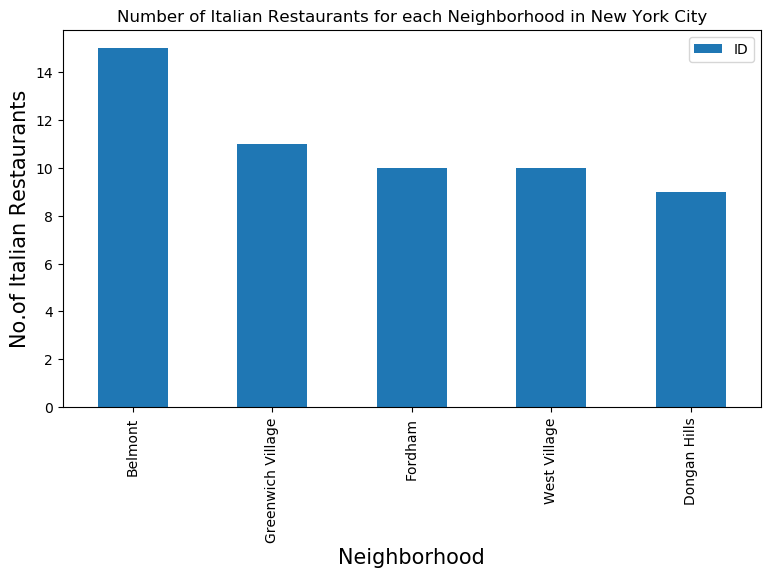

In [43]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [44]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

Borough Neighborhood                        ID  \
46   Bronx      Belmont  4acf80aef964a52025d420e3   
47   Bronx      Belmont  4bb6470cef159c7465b275f7   
48   Bronx      Belmont  4af0fa29f964a52060e021e3   
49   Bronx      Belmont  4aa425bef964a5208e4520e3   
50   Bronx      Belmont  4b5514c4f964a5207cda27e3   
51   Bronx      Belmont  4af71916f964a520cf0522e3   
52   Bronx      Belmont  4b5a4c8ff964a52049bb28e3   
53   Bronx      Belmont  59050f51b23dfa5f6649e678   
54   Bronx      Belmont  4c9b9e7b9c663704b90463fd   
55   Bronx      Belmont  4aa193d5f964a520124120e3   
56   Bronx      Belmont  4a8e261cf964a5201c1220e3   
57   Bronx      Belmont  4c79d294278eb713f6a05580   
58   Bronx      Belmont  4cb0d382ef1b370419643e00   
59   Bronx      Belmont  4b5bc595f964a520431529e3   
60   Bronx      Belmont  53ff939c498e6b601dfa3979   

                                                 Name  
46                                Tino's Delicatessen  
47                                Calabria Pork Store  
48                                Antonio's Trattoria  
49                              Dominick's Restaurant  
50                                             Enzo's  
51  Michaelangelo's Coal Fired Brick Oven Pizza Re...  
52                                Emilia's Restaurant  
53                               Arthur Avenue Fiasco  
54                                 Gerbasi Ristorante  
55                      Mario's Restaurant & Catering  
56                                          Roberto's  
57                                    Cafe al Mercato  
58              David Greco's Arthur Avenue Trattoria  
59                              Pasquale Riggaletto's  
60                             San Gennaro Ristorante

# Get details of Italian Restaurants in Bronx

In [46]:
# prepare neighborhood list that contains italian restaurants in Bronx
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_Bronx=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_Bronx.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_Bronx),')','processed')
    italian_rest_stats_Bronx = italian_rest_stats_Bronx.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.1     4
( 1 / 86 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.1     4
( 2 / 86 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.5    14
( 3 / 86 ) processed
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.8     8
( 4 / 86 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.6     6
( 5 / 86 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     26     7.4     8
( 6 / 86 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96ae65317

# Get details of Italian Restaurants in Brooklyn

In [47]:
# prepare neighborhood list that contains italian restaurants in Brooklyn
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_Brooklyn=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_Brooklyn.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_Brooklyn),')','processed')
    italian_rest_stats_Brooklyn = italian_rest_stats_Brooklyn.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID           Name  Likes  Rating  Tips
0  4b70d8dff964a52063312de3  Tuscany Grill     15     7.9     7
( 1 / 115 ) processed
                         ID                      Name  Likes  Rating  Tips
0  3fd66200f964a5205fee1ee3  Ponte Vecchio Restaurant     39     7.8    17
( 2 / 115 ) processed
                         ID      Name  Likes  Rating  Tips
0  4ad62c95f964a5208d0521e3  Zio Toto     16     7.2    34
( 3 / 115 ) processed
                         ID               Name  Likes  Rating  Tips
0  4bd075f2caff952145d3cef0  Gino's Restaurant    139     8.3    57
( 4 / 115 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4a7e205ef964a52012f11fe3  Sofia Restorante Italiano     15     7.0    10
( 5 / 115 ) processed
                         ID                                    Name  Likes  \
0  4e732dff45dd41e9ccce1987  Giacomo's Wood Fired Pizza & Trattoria     23   

   Rating  Tips  
0     7.1    20  
( 6 / 115 ) p

# Get details of Italian Restaurants in Manhattan

In [48]:
# prepare neighborhood list that contains italian restaurants in Manhattan
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_Manhattan=pd.DataFrame(columns=column_names)
count=1

for row in italian_rest_Manhattan.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_Manhattan),')','processed')
    italian_rest_stats_Manhattan = italian_rest_stats_Manhattan.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID               Name  Likes  Rating  Tips
0  4d21107c6e8c37042b58ff9f  Saggio Restaurant    119     8.7    62
( 1 / 138 ) processed
                         ID  Name  Likes  Rating  Tips
0  56d8e01d498ef1500ae7fbfe  Fumo    102     9.0    22
( 2 / 138 ) processed
                         ID            Name  Likes  Rating  Tips
0  558c6d42498eab8b9ee8da37  Bono Trattoria    101     8.7    19
( 3 / 138 ) processed
                         ID                 Name  Likes  Rating  Tips
0  457f1183f964a5204b3f1fe3  Pisticci Ristorante    403     9.1   146
( 4 / 138 ) processed
                         ID       Name  Likes  Rating  Tips
0  4c956003f7cfa1cd2e2ebd15  Bettolona     91     8.0    40
( 5 / 138 ) processed
                         ID  Name  Likes  Rating  Tips
0  56d8e01d498ef1500ae7fbfe  Fumo    102     9.0    22
( 6 / 138 ) processed
                         ID      Name  Likes  Rating  Tips
0  3fd66200f964a52006e91ee3  Max SoHa    112     7.9    60
( 7 

# Get details of Italian Restaurants in Queens

In [64]:
# prepare neighborhood list that contains italian restaurants in Queens
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_Queens=pd.DataFrame(columns=column_names)
count=1

for row in italian_rest_Queens.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_Queens),')','processed')
    italian_rest_stats_Queens = italian_rest_stats_Queens.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                          Name  Likes  Rating  Tips
0  5010b169e4b05edd9983ec7d  Antika Restaurant & Pizzeria     72     8.2    31
( 1 / 105 ) processed
                         ID        Name  Likes  Rating  Tips
0  4ebf0e380aaf6450ba608920  Via Trenta     57     7.7    28
( 2 / 105 ) processed
                         ID             Name  Likes  Rating  Tips
0  53a60a88498ef405d8a78217  VITE vinosteria    106     8.8    30
( 3 / 105 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4bc11e07920eb713d6491a2c  Donato's Restaurant     23     7.2     9
( 4 / 105 ) processed
                         ID           Name  Likes  Rating  Tips
0  4a82d6adf964a5206ff91fe3  Uncle Peter's     42     8.9    11
( 5 / 105 ) processed
                         ID              Name  Likes  Rating  Tips
0  4bae3bd0f964a52009963be3  Brothers Ravioli     10     8.1     2
( 6 / 105 ) processed
                         ID                Name  Likes

# Get details of Italian Restaurants in Staten Island

In [106]:
# prepare neighborhood list that contains italian restaurants in Staten Island
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_Staten_Island=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_Staten_Island.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_Staten_Island),')','processed')
    italian_rest_stats_Staten_Island = italian_rest_stats_Staten_Island.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  590928301de7651d663ae087  Marie's 2      9     8.1     2
( 1 / 108 ) processed
                         ID           Name  Likes  Rating  Tips
0  4a271f0cf964a5205c911fe3  Enoteca Maria     92     7.6    40
( 2 / 108 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4b76d8dbf964a520be632ee3  Pier 76 Italian Restaurant     79     7.9    44
( 3 / 108 ) processed
                         ID       Name  Likes  Rating  Tips
0  590928301de7651d663ae087  Marie's 2      9     8.1     2
( 4 / 108 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4b76d8dbf964a520be632ee3  Pier 76 Italian Restaurant     79     7.9    44
( 5 / 108 ) processed
                         ID           Name  Likes  Rating  Tips
0  4a271f0cf964a5205c911fe3  Enoteca Maria     92     7.6    40
( 6 / 108 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: 

# Compile the Italian Restaurants data for all 5 Boroughs

In [107]:
italian_rest_stats_ny = italian_rest_stats_Bronx.append(italian_rest_stats_Brooklyn,ignore_index=True).append(italian_rest_stats_Manhattan,ignore_index=True).append(italian_rest_stats_Queens,ignore_index=True).append(italian_rest_stats_Staten_Island,ignore_index=True)

In [108]:
italian_rest_stats_Bronx.shape

(86, 7)

In [109]:
italian_rest_stats_Bronx

Borough        Neighborhood                        ID  \
0    Bronx           Riverdale  55aaee4d498e3cbb70e625d6   
1    Bronx         Kingsbridge  55aaee4d498e3cbb70e625d6   
2    Bronx            Woodlawn  511edb6de4b0d58346fd272d   
3    Bronx            Woodlawn  4d3cb3026b3d236a066a6364   
4    Bronx          Baychester  4c9518076b35a143d5dc21dc   
5    Bronx          Baychester  5411894d498e4a254a11a46c   
6    Bronx      Pelham Parkway  4bf96ae65317a593d837017f   
7    Bronx      Pelham Parkway  4b10591af964a5205f6e23e3   
8    Bronx      Pelham Parkway  4b47f069f964a5208c4426e3   
9    Bronx         City Island  4514ed4df964a520e5391fe3   
10   Bronx         City Island  55905336498e1a9217de2a7a   
11   Bronx         City Island  4b80a1c3f964a520488230e3   
12   Bronx        Bedford Park  4b1712a8f964a520dbc123e3   
13   Bronx             Fordham  4acf80aef964a52025d420e3   
14   Bronx             Fordham  4bb6470cef159c7465b275f7   
15   Bronx             Fordham  4aa425bef964a5208e4520e3   
16   Bronx             Fordham  4b5514c4f964a5207cda27e3   
17   Bronx             Fordham  4b5a4c8ff964a52049bb28e3   
18   Bronx             Fordham  4af71916f964a520cf0522e3   
19   Bronx             Fordham  59050f51b23dfa5f6649e678   
20   Bronx             Fordham  4c9b9e7b9c663704b90463fd   
21   Bronx             Fordham  53ff939c498e6b601dfa3979   
22   Bronx             Fordham  4bc67f1104e8b713a833362d   
23   Bronx             Melrose  5956be26123a195de6701c2b   
24   Bronx             Melrose  4bb692672ea19521a6ecab2f   
25   Bronx          Mott Haven  4e6acfb1ae60950955a9b02b   
26   Bronx          Morrisania  5956be26123a195de6701c2b   
27   Bronx         Throgs Neck  4b4e3e87f964a5209de626e3   
28   Bronx         Throgs Neck  4b958fccf964a52091a934e3   
29   Bronx         Throgs Neck  4d4456d93616b60c953fe3c2   
30   Bronx         Throgs Neck  4c1d717b8b3aa59363a99a5f   
31   Bronx         Throgs Neck  4b6cb1c0f964a520d04c2ce3   
32   Bronx         Throgs Neck  4b491198f964a5208f6426e3   
33   Bronx        Country Club  4c9e1ef2542b224b70a3f09f   
34   Bronx        Country Club  4b85b6b3f964a5209b6e31e3   
35   Bronx        Country Club  4b634812f964a520936f2ae3   
36   Bronx        Country Club                         0   
37   Bronx  Westchester Square  51aa5120498ec578a5ad0ac4   
38   Bronx            Van Nest  3fd66200f964a5207bf11ee3   
39   Bronx            Van Nest  4bd1d5fdcaff95211c6ed1f0   
40   Bronx         Morris Park  4b10591af964a5205f6e23e3   
41   Bronx         Morris Park  4bf96ae65317a593d837017f   
42   Bronx         Morris Park  4bd1d5fdcaff95211c6ed1f0   
43   Bronx         Morris Park  51aa5120498ec578a5ad0ac4   
44   Bronx         Morris Park  4b47f069f964a5208c4426e3   
45   Bronx         Morris Park                         0   
46   Bronx             Belmont  4acf80aef964a52025d420e3   
47   Bronx             Belmont  4bb6470cef159c7465b275f7   
48   Bronx             Belmont  4af0fa29f964a52060e021e3   
49   Bronx             Belmont  4aa425bef964a5208e4520e3   
50   Bronx             Belmont  4b5514c4f964a5207cda27e3   
51   Bronx             Belmont  4af71916f964a520cf0522e3   
52   Bronx             Belmont  4b5a4c8ff964a52049bb28e3   
53   Bronx             Belmont  59050f51b23dfa5f6649e678   
54   Bronx             Belmont  4c9b9e7b9c663704b90463fd   
55   Bronx             Belmont  4aa193d5f964a520124120e3   
56   Bronx             Belmont  4a8e261cf964a5201c1220e3   
57   Bronx             Belmont  4c79d294278eb713f6a05580   
58   Bronx             Belmont  4cb0d382ef1b370419643e00   
59   Bronx             Belmont  4b5bc595f964a520431529e3   
60   Bronx             Belmont  53ff939c498e6b601dfa3979   
61   Bronx      Spuyten Duyvil  55aaee4d498e3cbb70e625d6   
62   Bronx     North Riverdale  4b3bdd2cf964a520f57c25e3   
63   Bronx     North Riverdale  4b451a29f964a520ad0426e3   
64   Bronx          Pelham Bay  4b85b6b3f964a5209b6e31e3   
65   Bronx          Pelham Bay  4c9e1ef2542

In [110]:
italian_rest_stats_Brooklyn.shape

(115, 7)

In [111]:
italian_rest_stats_Brooklyn

Borough               Neighborhood                        ID  \
0    Brooklyn                  Bay Ridge  4b70d8dff964a52063312de3   
1    Brooklyn                  Bay Ridge  3fd66200f964a5205fee1ee3   
2    Brooklyn                  Bay Ridge  4ad62c95f964a5208d0521e3   
3    Brooklyn                  Bay Ridge  4bd075f2caff952145d3cef0   
4    Brooklyn                  Bay Ridge  4a7e205ef964a52012f11fe3   
5    Brooklyn                  Bay Ridge  4e732dff45dd41e9ccce1987   
6    Brooklyn                Bensonhurst  4e30a139483bb3fdc436a7e3   
7    Brooklyn                Bensonhurst  4ae23a80f964a5200c8c21e3   
8    Brooklyn                Bensonhurst  4e073239cc3f1ed1312dce37   
9    Brooklyn                Bensonhurst  4c0791492e80a593eabf75f9   
10   Brooklyn                Sunset Park  5095a98ae4b0038a605e6f45   
11   Brooklyn                 Greenpoint  5424b085498ec9a9cdb44b70   
12   Brooklyn                 Greenpoint  5c6ddee8de3bbf002c44d83c   
13   Brooklyn                  Gravesend  4ad8c329f964a520731421e3   
14   Brooklyn             Sheepshead Bay  5a10a9d76e465053a63ca8c7   
15   Brooklyn             Sheepshead Bay  4c9e81bb54c8a1cdea8f8e4b   
16   Brooklyn             Sheepshead Bay  4ad9fb95f964a520bb1c21e3   
17   Brooklyn             Sheepshead Bay  55466c7e498e28eca31fc3e9   
18   Brooklyn             Sheepshead Bay  4c03fc29f423a59314f7d016   
19   Brooklyn                   Flatbush  52b90597498ed57b85609429   
20   Brooklyn            Windsor Terrace  4ec7fa185c5ce271be2b2bfa   
21   Brooklyn            Windsor Terrace  4a85fd26f964a520f4ff1fe3   
22   Brooklyn            Windsor Terrace  582466b8a130da5121eb7b36   
23   Brooklyn            Windsor Terrace  4d7c069273ca54818e2c577c   
24   Brooklyn            Windsor Terrace  5689b018498e9a7081b667e3   
25   Brooklyn               Williamsburg  5cdf51a01f74400039a39cdf   
26   Brooklyn                   Bushwick  5a98aed16a59506d7a60d67c   
27   Brooklyn                   Bushwick  587fad59e786b27f550ce708   
28   Brooklyn           Brooklyn Heights  4be30f9dd27a20a1cd1f915b   
29   Brooklyn           Brooklyn Heights  3fd66200f964a520ece81ee3   
30   Brooklyn           Brooklyn Heights  5a0740a3e1f22816d11723d5   
31   Brooklyn           Brooklyn Heights  5044f749e4b0dd909d2cc123   
32   Brooklyn                Cobble Hill  5a0740a3e1f22816d11723d5   
33   Brooklyn                Cobble Hill  5044f749e4b0dd909d2cc123   
34   Brooklyn                Cobble Hill  593329652632ec0582bd71df   
35   Brooklyn                Cobble Hill  5bdcfb3e6e69af0025d9e331   
36   Brooklyn                Cobble Hill  3fd66200f964a52042f11ee3   
37   Brooklyn                Cobble Hill  4be30f9dd27a20a1cd1f915b   
38   Brooklyn            Carroll Gardens  49c4ff90f964a520da561fe3   
39   Brooklyn            Carroll Gardens  41abb800f964a520561e1fe3   
40   Brooklyn            Carroll Gardens  4aa85f31f964a520075120e3   
41   Brooklyn            Carroll Gardens  5c034c3ff5e9d7002c2a78b1   
42   Brooklyn            Carroll Gardens  5766ad56498ebf269c3737d2   
43   Brooklyn            Carroll Gardens  5a56ac38dd70c54d5825002f   
44   Brooklyn            Carroll Gardens  4bba7fbe3db7b7131269239a   
45   Brooklyn                    Gowanus  41abb800f964a520561e1fe3   
46   Brooklyn                    Gowanus  5c034c3ff5e9d7002c2a78b1   
47   Brooklyn                    Gowanus  49d10b5af964a520545b1fe3   
48   Brooklyn                    Gowanus  49c4ff90f964a520da561fe3   
49   Brooklyn                Fort Greene  5a00f3538496ca58fd9e2856   
50   Brooklyn                Fort Greene  4c2d1eb17d85a593fa1452f3   
51   Brooklyn                Fort Greene  4afca48af964a520ab2422e3   
52   Brooklyn                Fort Greene  57a3dfc8498e490e4b231778   
53   Brooklyn                Fort Greene  4fbabf08e4b0ffe177a56434   
54   Brooklyn                 Park Slope  44bcb47ef964a5209b351fe3   
55   Brooklyn                 Park Slope  59f280813b83077c0957ae68   
56   Brooklyn   

In [112]:
italian_rest_stats_Manhattan.shape

(138, 7)

In [113]:
italian_rest_stats_Manhattan

Borough         Neighborhood                        ID  \
0    Manhattan   Washington Heights  4d21107c6e8c37042b58ff9f   
1    Manhattan     Hamilton Heights  56d8e01d498ef1500ae7fbfe   
2    Manhattan     Hamilton Heights  558c6d42498eab8b9ee8da37   
3    Manhattan       Manhattanville  457f1183f964a5204b3f1fe3   
4    Manhattan       Manhattanville  4c956003f7cfa1cd2e2ebd15   
5    Manhattan       Manhattanville  56d8e01d498ef1500ae7fbfe   
6    Manhattan       Manhattanville  3fd66200f964a52006e91ee3   
7    Manhattan       Central Harlem  56d8e01d498ef1500ae7fbfe   
8    Manhattan          East Harlem  3fd66200f964a5207de81ee3   
9    Manhattan          East Harlem  51800134e4b03b4e898c8f16   
10   Manhattan          East Harlem  53effc79498eddd22101127d   
11   Manhattan      Upper East Side  4a22d7f9f964a520977d1fe3   
12   Manhattan      Upper East Side  4a6133a6f964a52015c21fe3   
13   Manhattan      Upper East Side  4ab972d6f964a520697f20e3   
14   Manhattan      Upper East Side  42699000f964a52049211fe3   
15   Manhattan      Upper East Side  56bce4c5498ef768f74f4e6c   
16   Manhattan      Upper East Side  562c1df4498e2c64fb4a9faa   
17   Manhattan      Upper East Side  4b23ee1ef964a520255d24e3   
18   Manhattan            Yorkville  4e4078922271a89dd083d07e   
19   Manhattan            Yorkville  4b623700f964a520a83c2ae3   
20   Manhattan            Yorkville  4b651459f964a52030e32ae3   
21   Manhattan            Yorkville  4b981d9af964a520802d35e3   
22   Manhattan            Yorkville  504bb0fae4b0d1cf33ca07d0   
23   Manhattan            Yorkville  562c1df4498e2c64fb4a9faa   
24   Manhattan           Lenox Hill  4b775e32f964a520a6952ee3   
25   Manhattan           Lenox Hill  42699000f964a52049211fe3   
26   Manhattan           Lenox Hill  4a6133a6f964a52015c21fe3   
27   Manhattan           Lenox Hill  51c9e3f9498e2cb9c31d19ff   
28   Manhattan           Lenox Hill  56bce4c5498ef768f74f4e6c   
29   Manhattan     Roosevelt Island  4b775e32f964a520a6952ee3   
30   Manhattan     Roosevelt Island  4b495fb4f964a520a36e26e3   
31   Manhattan      Upper West Side  42489a80f964a5208a201fe3   
32   Manhattan      Upper West Side  56afed04498e39e35747adf2   
33   Manhattan      Upper West Side  4d68839467a8f04df7ee01be   
34   Manhattan      Upper West Side  4a7778a1f964a5209be41fe3   
35   Manhattan      Upper West Side  5282b4bf11d2b180cc775713   
36   Manhattan       Lincoln Square  459395b7f964a52047401fe3   
37   Manhattan       Lincoln Square  4b69b408f964a520c5ae2be3   
38   Manhattan       Lincoln Square  54961b98498eccc96c4a93d7   
39   Manhattan       Lincoln Square  548a64ae498e972164140a84   
40   Manhattan              Clinton  5633bec0498e430fc8ba8f3c   
41   Manhattan              Clinton  4dcae1b18877502200c95822   
42   Manhattan              Clinton  49d5651df964a520915c1fe3   
43   Manhattan              Chelsea  511d6006e4b0a486ec088c89   
44   Manhattan              Chelsea  56a1214f498e7512685bb8a1   
45   Manhattan              Chelsea  4533d338f964a5208f3b1fe3   
46   Manhattan    Greenwich Village  504b2a9ee4b006c435a465d3   
47   Manhattan    Greenwich Village  5ab53749446ea6289e41b0e6   
48   Manhattan    Greenwich Village  556f4ef2498ee60139b28c72   
49   Manhattan    Greenwich Village  56d92e05498e6c54b6325b19   
50   Manhattan    Greenwich Village  51278a09e4b0b624edbc914c   
51   Manhattan    Greenwich Village  543075b3498e283e38ad9dec   
52   Manhattan    Greenwich Village  3fd66200f964a5202de71ee3   
53   Manhattan    Greenwich Village  4cc6222106c25481d7a4a047   
54   Manhattan    Greenwich Village  4d9f8d97a428a1cdd92acb04   
55   Manhattan    Greenwich Village  534c7a27498efe3d035cbbe9   
56   Manhattan    Greenwich Village  54459a46498ecf8ec204cc61   
57   Manhattan         East Village  40f1d480f964a520680a1fe3   
58   Manhattan         East Village  4575b847f964a520a13e1fe3   
59   Manhattan      Lower East Side  56cf3493cd106ae44d0c76a8   
60   Manhattan      Lower East Side  4d49d

In [114]:
italian_rest_stats_Queens.shape

(105, 7)

In [115]:
italian_rest_stats_Queens

Borough          Neighborhood                        ID  \
0    Queens               Astoria  5010b169e4b05edd9983ec7d   
1    Queens               Astoria  4ebf0e380aaf6450ba608920   
2    Queens               Astoria  53a60a88498ef405d8a78217   
3    Queens              Woodside  4bc11e07920eb713d6491a2c   
4    Queens       Jackson Heights  4a82d6adf964a5206ff91fe3   
5    Queens          Howard Beach  4bae3bd0f964a52009963be3   
6    Queens          Howard Beach  4bafdb5df964a52086263ce3   
7    Queens          Howard Beach  4e6409451495676d566f10b5   
8    Queens          Howard Beach  4ba148f5f964a5201da937e3   
9    Queens                Corona  4b808501f964a5207b7930e3   
10   Queens                Corona  4ea2fc90cc2102b34d3d8dc7   
11   Queens                Corona                         0   
12   Queens          Forest Hills  4c8d2ce6f87e224bfb6d3b05   
13   Queens          Forest Hills  4ba0203af964a520105c37e3   
14   Queens           Kew Gardens  4c93eb6a72dd224be41d9591   
15   Queens         Richmond Hill  4c93eb6a72dd224be41d9591   
16   Queens      Long Island City  5aa41faf178a2a08410ce198   
17   Queens      Long Island City  53ed8f36498ea1eca81563c1   
18   Queens             Sunnyside  555d29f7498eb6112f44ecac   
19   Queens             Sunnyside  4ce1741194c3b60c5dc776ea   
20   Queens         East Elmhurst  5480b6d4498e6e352f7a8d3e   
21   Queens               Maspeth  5c6183b006fb60002ca6572b   
22   Queens               Maspeth  513d152ee4b0d54ade774b14   
23   Queens             Ridgewood  4b89b361f964a520074c32e3   
24   Queens             Ridgewood  4c1e7c9e63750f47d5d3b967   
25   Queens             Ridgewood  4dcf12c8fa7664b7c6b91801   
26   Queens              Glendale                         0   
27   Queens             Rego Park  4c50f9ae9d642d7f357fc6dc   
28   Queens            Ozone Park  4cb21cebdb32f04db2a7cd4d   
29   Queens      South Ozone Park  4ac7e812f964a5207fba20e3   
30   Queens            Whitestone  4ebc34954690a29fd6be2e82   
31   Queens            Whitestone  4ba3d448f964a5200c6438e3   
32   Queens            Whitestone  56071182498e48b25409f3b5   
33   Queens            Whitestone  4bc1f7b6461576b025907c32   
34   Queens            Whitestone  4d290280342d6dcb91a7feca   
35   Queens               Bayside  4bb7ca5b1261d13a83e2e798   
36   Queens               Bayside  4d4e0113869cf04dd10ce4ae   
37   Queens               Bayside  4b89d531f964a520f54f32e3   
38   Queens            Auburndale  4b96ab2af964a520bfdc34e3   
39   Queens            Auburndale  4c0aeaa1340720a1fd5b8793   
40   Queens            Auburndale                         0   
41   Queens           Little Neck  4bc8f64c0687ef3bda0bd9cc   
42   Queens           Little Neck  4bae85bef964a52073bc3be3   
43   Queens           Little Neck  528ffa0b11d2ea463d2cd25c   
44   Queens           Little Neck  4bc0cad874a9a59398afd0f6   
45   Queens           Little Neck  4c1a9ed0b4e62d7fa119d893   
46   Queens           Little Neck  4bd23c50caff95215f71d2f0   
47   Queens            Douglaston  4bc8f64c0687ef3bda0bd9cc   
48   Queens            Douglaston  4bc0cad874a9a59398afd0f6   
49   Queens            Douglaston  4bae85bef964a52073bc3be3   
50   Queens            Douglaston  4bd23c50caff95215f71d2f0   
51   Queens            Douglaston  4c1a9ed0b4e62d7fa119d893   
52   Queens             Glen Oaks  4c450fae74ffc928328676cc   
53   Queens             Bellerose  4cf009ae7b94370446c43653   
54   Queens             Bellerose  4d0ab4386aa05481d5f5e5aa   
55   Queens       Oakland Gardens  4c1e3a9f8b3aa593b4b49b5f   
56   Queens       Oakland Gardens  4b9c519ef964a520065f36e3   
57   Queens              Steinway  5c087e308264440039684a37   
58   Queens              Steinway  4afc64a8f964a520382222e3   
59   Queens              Steinway  4b494398f964a520d96b26e3   
60   Queens              Steinway  53a618d4498ea7107dabe020   
61   Queens              Steinway  4b26d60cf964a520b58124e3   
62   Queens            Beechhurst  

In [116]:
italian_rest_stats_Staten_Island.shape

(108, 7)

In [117]:
italian_rest_stats_Staten_Island

Borough       Neighborhood                        ID  \
0    Staten Island         St. George  590928301de7651d663ae087   
1    Staten Island         St. George  4a271f0cf964a5205c911fe3   
2    Staten Island         St. George  4b76d8dbf964a520be632ee3   
3    Staten Island       New Brighton  590928301de7651d663ae087   
4    Staten Island       New Brighton  4b76d8dbf964a520be632ee3   
5    Staten Island       New Brighton  4a271f0cf964a5205c911fe3   
6    Staten Island          Stapleton                         0   
7    Staten Island           Rosebank  4bcc8e3bb6c49c7422ed9391   
8    Staten Island           Rosebank  4e179bdc52b123a586ceea11   
9    Staten Island           Rosebank  4bbb8986e452952190d154a4   
10   Staten Island           Rosebank                         0   
11   Staten Island      West Brighton  4b5b58dbf964a52088f628e3   
12   Staten Island      West Brighton  4bf872974a67c928b57725cf   
13   Staten Island      West Brighton  4b6b0b96f964a52001ef2be3   
14   Staten Island   Mariner's Harbor  4d51deac3062a1cd37786ba3   
15   Staten Island   Mariner's Harbor                         0   
16   Staten Island   Mariner's Harbor                         0   
17   Staten Island  Castleton Corners  4b9a599af964a5201aae35e3   
18   Staten Island  Castleton Corners  4e35b9daaeb7f67fbd346ef9   
19   Staten Island             Travis  4ad910d8f964a520b81721e3   
20   Staten Island           New Dorp  4b343839f964a5203a2625e3   
21   Staten Island           New Dorp  4be61580d4f7c9b6fe662620   
22   Staten Island           New Dorp  4bc73ff96501c9b696063e29   
23   Staten Island           New Dorp  4b9fb541f964a520fd3637e3   
24   Staten Island           New Dorp                         0   
25   Staten Island        Great Kills  517dbe77e4b0eef580c875a3   
26   Staten Island        Great Kills  5182ef83498e59069ff5e71b   
27   Staten Island        Great Kills  4d4b4295ad4a6ea89135fbe9   
28   Staten Island        Great Kills  4cb8efaa90c9a143a5e183d6   
29   Staten Island        Great Kills                         0   
30   Staten Island        Eltingville  4c4a44f9bad7a593ee641daa   
31   Staten Island        Eltingville  5182ef83498e59069ff5e71b   
32   Staten Island        Eltingville                         0   
33   Staten Island        Tottenville  4bf08bf117880f47a3782937   
34   Staten Island        Tottenville  59fc9f85f193c02897fc2369   
35   Staten Island        Tottenville  537e9b77498e6816a1f38ca6   
36   Staten Island        Tottenville                         0   
37   Staten Island        Tottenville                         0   
38   Staten Island      Tompkinsville  4b76d8dbf964a520be632ee3   
39   Staten Island      Tompkinsville  590928301de7651d663ae087   
40   Staten Island      Tompkinsville  4a271f0cf964a5205c911fe3   
41   Staten Island        Westerleigh  4b8a719df964a520016d32e3   
42   Staten Island       Graniteville                         0   
43   Staten Island           Arrochar  4bddbdea587b2d7fc5e25409   
44   Staten Island           Arrochar  4c2546d5a852c928e5a2e46c   
45   Staten Island           Grasmere  4b803abff964a520cd5e30e3   
46   Staten Island           Grasmere  4be73347d4f7c9b66c992720   
47   Staten Island           Grasmere  4b9bdbd8f964a5201e2e36e3   
48   Staten Island           Grasmere  4c2546d5a852c928e5a2e46c   
49   Staten Island           Grasmere                         0   
50   Staten Island           Old Town  4bcf46d4a8b3a593fae6615f   
51   Staten Island           Old Town  4be73347d4f7c9b66c992720   
52   Staten Island           Old Town  4303cf80f964a5201c271fe3   
53   Staten Island           Old Town  4b9bdbd8f964a5201e2e36e3   
54   Staten Island           Old Town  4b803abff964a520cd5e30e3   
55   Staten Island           Old Town  4daa28bd93a04642f079c973   
56   Staten Island           Old Town  4af72d60f964a520ce0622e3   
57   Staten Island       Dongan Hills  4ba80534f964a520f6c639e3   
58   Staten Island       Dongan Hills  54e13989498ed2a42c1

In [118]:
italian_rest_stats_ny.shape

(552, 7)

# Save the Restaurants data in a csv file

In [119]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny.csv', index=False)

In [120]:
# verify the data in csv
italian_rest_stats_ny_csv=pd.read_csv('italian_rest_stats_ny.csv')

In [121]:
italian_rest_stats_ny_csv.shape

(552, 7)

In [122]:
italian_rest_stats_ny_csv.head()

Borough Neighborhood                        ID                    Name  \
0   Bronx    Riverdale  55aaee4d498e3cbb70e625d6    Bella Notte Pizzeria   
1   Bronx  Kingsbridge  55aaee4d498e3cbb70e625d6    Bella Notte Pizzeria   
2   Bronx     Woodlawn  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn   
3   Bronx     Woodlawn  4d3cb3026b3d236a066a6364             Rivers Edge   
4   Bronx   Baychester  4c9518076b35a143d5dc21dc              Fratelli's   

   Likes  Rating  Tips  
0      9     7.1     4  
1      9     7.1     4  
2     18     8.5    14  
3     10     6.8     8  
4     22     8.6     6

In [123]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       552 non-null    object 
 1   Neighborhood  552 non-null    object 
 2   ID            552 non-null    object 
 3   Name          552 non-null    object 
 4   Likes         552 non-null    object 
 5   Rating        552 non-null    float64
 6   Tips          552 non-null    object 
dtypes: float64(1), object(6)
memory usage: 30.3+ KB


# Convert the data type of Likes and Tips to Float

In [124]:
# convert likes to float
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')

In [125]:
# convert Tips to float
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [126]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       552 non-null    object 
 1   Neighborhood  552 non-null    object 
 2   ID            552 non-null    object 
 3   Name          552 non-null    object 
 4   Likes         552 non-null    float64
 5   Rating        552 non-null    float64
 6   Tips          552 non-null    float64
dtypes: float64(3), object(4)
memory usage: 30.3+ KB


# Restaurant with maximum Likes

In [127]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2491
Rating                               9.2
Tips                                 825
Name: 254, dtype: object

# Restaurant with maximum Rating

In [128]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                          Carmenta’s
Likes                                 58
Rating                               9.5
Tips                                  21
Name: 112, dtype: object

# Restaurant with maximum Tips

In [129]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 22
Rating                               8.4
Tips                                1136
Name: 455, dtype: object

# Top 10 NYC neighborhoods with highly rated Italian Restaurants

In [130]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [131]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
23            Bushwick        9.150000
45            Downtown        9.100000
19         Boerum Hill        9.100000
56        Emerson Hill        9.100000
27      Central Harlem        9.000000
78          Greenpoint        9.000000
80   Greenwich Village        8.963636
150               Soho        8.925000
64         Fort Greene        8.920000
177       West Village        8.910000

# Average Rating of Italian Restaurants in the 5 NYC Boroughs

In [132]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [133]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False)

Borough  Average Rating
2      Manhattan        8.615217
1       Brooklyn        7.849565
0          Bronx        7.455814
3         Queens        7.160952
4  Staten Island        6.109259

# Plot the Average rating of Italian Restaurants by Borough

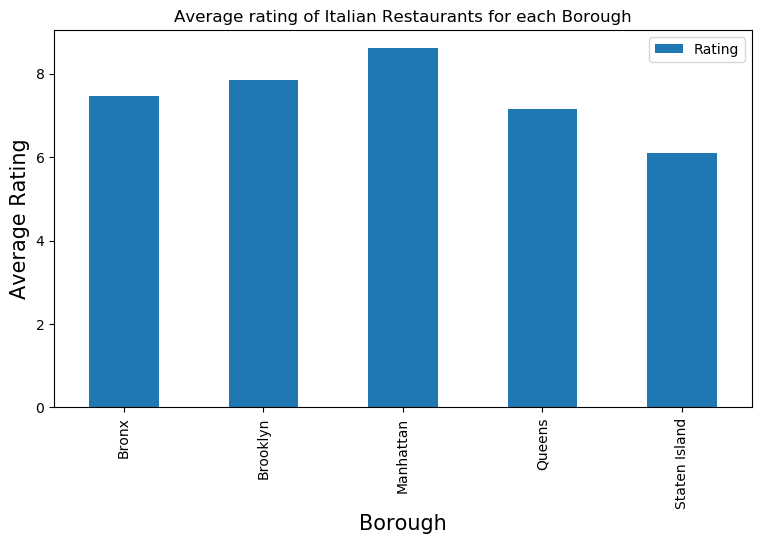

In [134]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italian Restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

# Get the list of NYC neighborhoods with an Average rating of 8.5 or higher

In [135]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [136]:
ny_neighborhood_stats

Neighborhood  Average Rating
19          Boerum Hill        9.100000
21     Brooklyn Heights        8.750000
23             Bushwick        9.150000
24        Carnegie Hill        8.566667
27       Central Harlem        9.000000
29              Chelsea        8.500000
31         Civic Center        8.733333
34         Clinton Hill        8.766667
35          Cobble Hill        8.583333
45             Downtown        9.100000
46                Dumbo        8.500000
50         East Village        8.650000
51    East Williamsburg        8.700000
56         Emerson Hill        9.100000
59             Flatiron        8.833333
60          Floral Park        8.500000
64          Fort Greene        8.920000
66         Fulton Ferry        8.500000
69            Glen Oaks        8.500000
72             Gramercy        8.575000
78           Greenpoint        9.000000
80    Greenwich Village        8.963636
81     Hamilton Heights        8.850000
88      Jackson Heights        8.900000
91          Lefrak City        8.650000
92           Lenox Hill        8.640000
96         Little Italy        8.875000
99      Lower East Side        8.733333
103    Manhattan Valley        8.500000
104      Manhattanville        8.500000
120                Noho        8.850000
122          North Side        8.900000
127          Park Slope        8.500000
129      Pelham Gardens        8.600000
137           Rego Park        8.500000
150                Soho        8.925000
162        Sutton Place        8.575000
167             Tribeca        8.600000
170     Upper East Side        8.585714
174        Vinegar Hill        8.500000
175  Washington Heights        8.700000
177        West Village        8.910000
186           Yorkville        8.616667

In [137]:
ny_neighborhood_stats.shape

(43, 2)

# Total of 43 Italian Restaurants with an average rating of 8.5 or higher

In [138]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

# Merge the Neighborhoods geospatial data with the ratings data

In [139]:
ny_neighborhood_stats

Neighborhood  Average Rating        Borough   Latitude  Longitude
0          Boerum Hill        9.100000       Brooklyn  40.685683 -73.983748
1     Brooklyn Heights        8.750000       Brooklyn  40.695864 -73.993782
2             Bushwick        9.150000       Brooklyn  40.698116 -73.925258
3        Carnegie Hill        8.566667      Manhattan  40.782683 -73.953256
4       Central Harlem        9.000000      Manhattan  40.815976 -73.943211
5              Chelsea        8.500000      Manhattan  40.744035 -74.003116
6              Chelsea        8.500000  Staten Island  40.594726 -74.189560
7         Civic Center        8.733333      Manhattan  40.715229 -74.005415
8         Clinton Hill        8.766667       Brooklyn  40.693229 -73.967843
9          Cobble Hill        8.583333       Brooklyn  40.687920 -73.998561
10            Downtown        9.100000       Brooklyn  40.690844 -73.983463
11               Dumbo        8.500000       Brooklyn  40.703176 -73.988753
12        East Village        8.650000      Manhattan  40.727847 -73.982226
13   East Williamsburg        8.700000       Brooklyn  40.708492 -73.938858
14        Emerson Hill        9.100000  Staten Island  40.606794 -74.097762
15            Flatiron        8.833333      Manhattan  40.739673 -73.990947
16         Floral Park        8.500000         Queens  40.741378 -73.708847
17         Fort Greene        8.920000       Brooklyn  40.688527 -73.972906
18        Fulton Ferry        8.500000       Brooklyn  40.703281 -73.995508
19           Glen Oaks        8.500000         Queens  40.749441 -73.715481
20            Gramercy        8.575000      Manhattan  40.737210 -73.981376
21          Greenpoint        9.000000       Brooklyn  40.730201 -73.954241
22   Greenwich Village        8.963636      Manhattan  40.726933 -73.999914
23    Hamilton Heights        8.850000      Manhattan  40.823604 -73.949688
24     Jackson Heights        8.900000         Queens  40.751981 -73.882821
25         Lefrak City        8.650000         Queens  40.736075 -73.862525
26          Lenox Hill        8.640000      Manhattan  40.768113 -73.958860
27        Little Italy        8.875000      Manhattan  40.719324 -73.997305
28     Lower East Side        8.733333      Manhattan  40.717807 -73.980890
29    Manhattan Valley        8.500000      Manhattan  40.797307 -73.964286
30      Manhattanville        8.500000      Manhattan  40.816934 -73.957385
31                Noho        8.850000      Manhattan  40.723259 -73.988434
32          North Side        8.900000       Brooklyn  40.714823 -73.958809
33          Park Slope        8.500000       Brooklyn  40.672321 -73.977050
34      Pelham Gardens        8.600000          Bronx  40.862966 -73.841612
35           Rego Park        8.500000         Queens  40.728974 -73.857827
36                Soho        8.925000      Manhattan  40.722184 -74.000657
37        Sutton Place        8.575000      Manhattan  40.760280 -73.963556
38             Tribeca        8.600000      Manhattan  40.721522 -74.010683
39     Upper East Side        8.585714      Manhattan  40.775639 -73.960508
40        Vinegar Hill        8.500000       Brooklyn  40.703321 -73.981116
41  Washington Heights        8.700000      Manhattan  40.851903 -73.936900
42        West Village        8.910000      Manhattan  40.734434 -74.006180
43           Yorkville        8.616667      Manhattan  40.775930 -73.947118

In [140]:
ny_neighborhood_stats.shape

(44, 5)

In [141]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [142]:
ny_neighborhood_stats.sort_values(by=['Average Rating'], ascending=False, inplace=True)
ny_neighborhood_stats

Borough        Neighborhood   Latitude  Longitude  Average Rating
2        Brooklyn            Bushwick  40.698116 -73.925258        9.150000
0        Brooklyn         Boerum Hill  40.685683 -73.983748        9.100000
10       Brooklyn            Downtown  40.690844 -73.983463        9.100000
14  Staten Island        Emerson Hill  40.606794 -74.097762        9.100000
21       Brooklyn          Greenpoint  40.730201 -73.954241        9.000000
4       Manhattan      Central Harlem  40.815976 -73.943211        9.000000
22      Manhattan   Greenwich Village  40.726933 -73.999914        8.963636
36      Manhattan                Soho  40.722184 -74.000657        8.925000
17       Brooklyn         Fort Greene  40.688527 -73.972906        8.920000
42      Manhattan        West Village  40.734434 -74.006180        8.910000
32       Brooklyn          North Side  40.714823 -73.958809        8.900000
24         Queens     Jackson Heights  40.751981 -73.882821        8.900000
27      Manhattan        Little Italy  40.719324 -73.997305        8.875000
31      Manhattan                Noho  40.723259 -73.988434        8.850000
23      Manhattan    Hamilton Heights  40.823604 -73.949688        8.850000
15      Manhattan            Flatiron  40.739673 -73.990947        8.833333
8        Brooklyn        Clinton Hill  40.693229 -73.967843        8.766667
1        Brooklyn    Brooklyn Heights  40.695864 -73.993782        8.750000
7       Manhattan        Civic Center  40.715229 -74.005415        8.733333
28      Manhattan     Lower East Side  40.717807 -73.980890        8.733333
13       Brooklyn   East Williamsburg  40.708492 -73.938858        8.700000
41      Manhattan  Washington Heights  40.851903 -73.936900        8.700000
25         Queens         Lefrak City  40.736075 -73.862525        8.650000
12      Manhattan        East Village  40.727847 -73.982226        8.650000
26      Manhattan          Lenox Hill  40.768113 -73.958860        8.640000
43      Manhattan           Yorkville  40.775930 -73.947118        8.616667
38      Manhattan             Tribeca  40.721522 -74.010683        8.600000
34          Bronx      Pelham Gardens  40.862966 -73.841612        8.600000
39      Manhattan     Upper East Side  40.775639 -73.960508        8.585714
9        Brooklyn         Cobble Hill  40.687920 -73.998561        8.583333
37      Manhattan        Sutton Place  40.760280 -73.963556        8.575000
20      Manhattan            Gramercy  40.737210 -73.981376        8.575000
3       Manhattan       Carnegie Hill  40.782683 -73.953256        8.566667
5       Manhattan             Chelsea  40.744035 -74.003116        8.500000
30      Manhattan      Manhattanville  40.816934 -73.957385        8.500000
35         Queens           Rego Park  40.728974 -73.857827        8.500000
11       Brooklyn               Dumbo  40.703176 -73.988753        8.500000
29      Manhattan    Manhattan Valley  40.797307 -73.964286        8.500000
16         Queens         Floral Park  40.741378 -73.708847        8.500000
18       Brooklyn        Fulton Ferry  40.703281 -73.995508        8.500000
40       Brooklyn        Vinegar Hill  40.703321 -73.981116        8.500000
6   Staten Island             Chelsea  40.594726 -74.189560        8.500000
19         Queens           Glen Oaks  40.749441 -73.715481        8.500000
33       Brooklyn          Park Slope  40.672321 -73.977050        8.500000

# Create a map and display the restaurants neighborhoods

In [143]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [144]:
# instantiate a feature group for the restaurants in the dataframe
restaurants = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the restaurants feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    restaurants.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [145]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [146]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add restaurnts to map
ny_map.add_child(restaurants)

# Visualize the Boroughs based on average Rating using a Choropleth Map

In [147]:
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')
ny_map

# Visit https://nbviewer.jupyter.org/github/pcomandur/Coursera-Capstone-Project/blob/master/The_Battle_of_NYC_Neighborhoods.ipynb to view the Notebook with Maps